In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import os
import sys
import geopandas as gpd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIdata = os.getenv('PUIDATA')
print(PUIdata)

/home/cusp/uc288/PUIdata


In [3]:
filename = PUIdata + '/dsny-tonnage.csv'

In [4]:
if (not os.path.isfile(filename)):
    print('File not found, downloading data...')
    os.system('curl -O https://data.cityofnewyork.us/api/views/ebb7-mvp5/rows.csv?accessType=DOWNLOAD')
    os.system('mv rows.csv?accessType=DOWNLOAD dsny-tonnage.csv')
    os.system('mv dsny-tonnage.csv ' + PUIdata)

if (os.path.isfile(filename)):
    print('File found, reading csv file: ' + filename)
    df = pd.read_csv(filename)

File found, reading csv file: /home/cusp/uc288/PUIdata/dsny-tonnage.csv


In [5]:
cd_zipfile = PUIdata + '/nycd_17c.zip'
cd_shpfile = PUIdata + '/nycd_17c/nycd.shp'

In [6]:
if (not os.path.isfile(cd_shpfile)):
    print('File not found, check for ZIP file...')
    
    if (not os.path.isfile(cd_zipfile)):
        print('ZIP file not found, downloading data...')
        os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycd_17c.zip')
        os.system('unzip nycd_17c.zip -d ' + PUIdata)

if (os.path.isfile(cd_shpfile)):
    print('File present, read shapefile')
    df_nyc = gpd.GeoDataFrame.from_file(cd_shpfile)

File present, read shapefile


In [7]:
df.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,BOROUGH_ID
0,2013 / 10,Queens,13,5189.25,505.94,573.44,4
1,2013 / 10,Brooklyn,7,3341.37,414.57,319.11,3
2,2013 / 10,Bronx,2,1545.83,72.33,92.12,2
3,2013 / 10,Queens,10,3785.36,375.29,343.98,4
4,2013 / 10,Manhattan,2,2167.47,446.13,294.68,1


In [8]:
df_nyc.head()

,BoroCD,Shape_Leng,Shape_Area,geometry
0,311,51549.557738,1.031778e+08,"POLYGON ((991748.3937988281 161084.9552001953,..."
1,314,49291.791502,8.217567e+07,"POLYGON ((996375.2443847656 177931.1611938477,..."
2,313,65746.939737,8.814953e+07,"POLYGON ((988770.7620239258 156350.5123901367,..."
3,310,44794.111421,1.113147e+08,"POLYGON ((975283.3026123047 173918.8842163086,..."
4,312,52245.830711,9.952550e+07,"POLYGON ((992187.4083862305 175455.467590332, ..."


In [9]:
df['YEAR'] = df.MONTH.str.split('/').str.get(0).str.strip()

In [10]:
df.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,BOROUGH_ID,YEAR
0,2013 / 10,Queens,13,5189.25,505.94,573.44,4,2013
1,2013 / 10,Brooklyn,7,3341.37,414.57,319.11,3,2013
2,2013 / 10,Bronx,2,1545.83,72.33,92.12,2,2013
3,2013 / 10,Queens,10,3785.36,375.29,343.98,4,2013
4,2013 / 10,Manhattan,2,2167.47,446.13,294.68,1,2013


In [11]:
df['BoroCD'] = df.BOROUGH_ID.map(str) + df.COMMUNITYDISTRICT.map(str).str.pad(2, fillchar='0')

In [12]:
df_group = df.groupby(['YEAR', 'BoroCD'])[['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED']].sum().reset_index()

In [13]:
df_nyc.shape

(71, 4)

In [14]:
df_group.head()

,YEAR,BoroCD,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED
0,2013,101,1364.36,352.27,195.61
1,2013,102,2167.47,446.13,294.68
2,2013,103,3102.04,320.67,256.21
3,2013,104,2408.54,414.43,321.44
4,2013,105,1356.06,256.67,163.21


In [15]:
df_group.BoroCD = pd.to_numeric(df_group.BoroCD)

In [16]:
df_group.describe()

,BoroCD,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED
count,295.000000,295.000000,295.000000,295.000000
mean,280.305085,33350.465966,3884.358746,3445.307017
std,117.958291,20256.360988,2880.474478,2274.806613
min,101.000000,1356.060000,72.330000,92.120000
25%,203.000000,19851.125000,1326.230000,1663.775000
50%,306.000000,33968.970000,3584.410000,3558.140000
75%,403.000000,48507.920000,5637.410000,4745.595000
max,503.000000,78448.850000,14350.940000,9269.640000


In [17]:
df_group['YEAR'] = pd.to_numeric(df_group['YEAR'])

In [18]:
thousands = lambda x : x / 1e3

In [19]:
df_group.PAPERTONSCOLLECTED = df_group.PAPERTONSCOLLECTED.apply(thousands)
df_group.MGPTONSCOLLECTED = df_group.MGPTONSCOLLECTED.apply(thousands)
df_group.REFUSETONSCOLLECTED = df_group.REFUSETONSCOLLECTED.apply(thousands)

In [20]:
df_group['TOTALTONS'] = df_group.REFUSETONSCOLLECTED + df_group.MGPTONSCOLLECTED + df_group.PAPERTONSCOLLECTED

In [21]:
df_group.head()

,YEAR,BoroCD,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,TOTALTONS
0,2013,101,1.36436,0.35227,0.19561,1.91224
1,2013,102,2.16747,0.44613,0.29468,2.90828
2,2013,103,3.10204,0.32067,0.25621,3.67892
3,2013,104,2.40854,0.41443,0.32144,3.14441
4,2013,105,1.35606,0.25667,0.16321,1.77594


In [22]:
df_group['REFUSERATIO'] = (df_group.REFUSETONSCOLLECTED / df_group.TOTALTONS) * 100
df_group['PAPERRATIO'] = (df_group.PAPERTONSCOLLECTED / df_group.TOTALTONS) * 100
df_group['MGPRATIO'] = (df_group.MGPTONSCOLLECTED / df_group.TOTALTONS) * 100

In [23]:
df_group.head()

,YEAR,BoroCD,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,TOTALTONS,REFUSERATIO,PAPERRATIO,MGPRATIO
0,2013,101,1.36436,0.35227,0.19561,1.91224,71.348785,18.421851,10.229365
1,2013,102,2.16747,0.44613,0.29468,2.90828,74.527556,15.339995,10.132449
2,2013,103,3.10204,0.32067,0.25621,3.67892,84.319311,8.716417,6.964272
3,2013,104,2.40854,0.41443,0.32144,3.14441,76.597517,13.179897,10.222585
4,2013,105,1.35606,0.25667,0.16321,1.77594,76.357309,14.452628,9.190063


In [24]:
df_all = df_nyc.merge(df_group[df_group['YEAR'] == 2016], on='BoroCD')

In [25]:
df_all.shape

(59, 12)

In [26]:
matplotlib.rcParams.update({'font.size': 15})

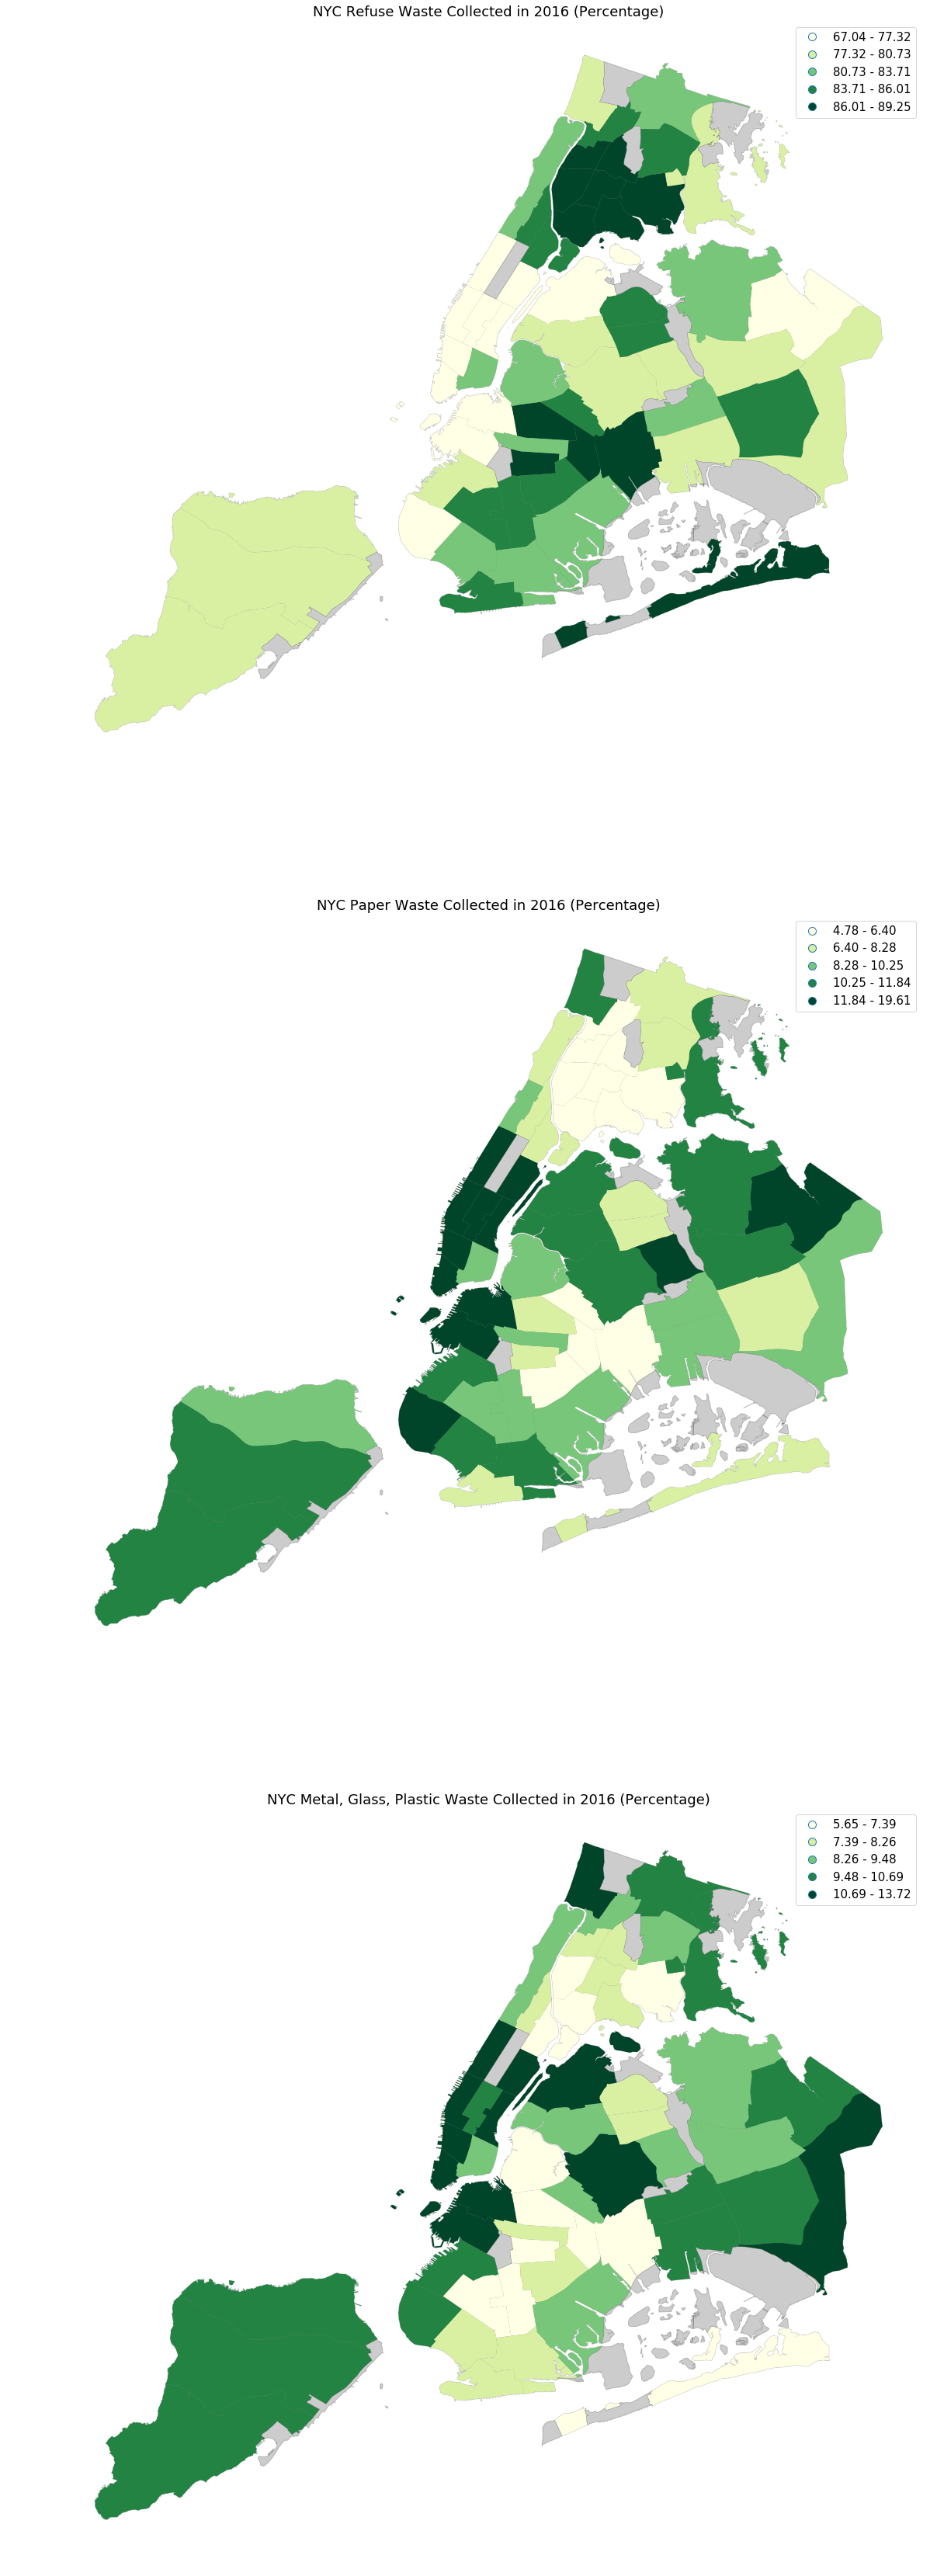

In [27]:
f, (ax1, ax2, ax3) = pl.subplots(3, 1, figsize=(20,60))

df_nyc.plot(ax=ax1, color='black', edgecolor='black', alpha=0.2)
df_all.plot(ax=ax1, column='REFUSERATIO', cmap='YlGn', scheme='quantiles', legend=True)
ax1.set_title('NYC Refuse Waste Collected in 2016 (Percentage)')
ax1.axis('off')

df_nyc.plot(ax=ax2, color='black', edgecolor='black', alpha=0.2)
df_all.plot(ax=ax2, column='PAPERRATIO', cmap='YlGn', scheme='quantiles', legend=True)
ax2.set_title('NYC Paper Waste Collected in 2016 (Percentage)')
ax2.axis('off')

df_nyc.plot(ax=ax3, color='black', edgecolor='black', alpha=0.2)
df_all.plot(ax=ax3, column='MGPRATIO', cmap='YlGn', scheme='quantiles', legend=True)
ax3.set_title('NYC Metal, Glass, Plastic Waste Collected in 2016 (Percentage)')
ax3.axis('off')

savefig('2016_trashratio.png')

In [28]:
df_yearly = df.groupby(['YEAR', 'BOROUGH'])[['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED']].sum().reset_index()

In [29]:
df_yearly.head()

,YEAR,BOROUGH,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED
0,2013,Bronx,34238.10,2369.21,2526.70
1,2013,Brooklyn,67884.06,7077.20,5242.85
2,2013,Manhattan,37498.21,5540.47,3802.36
3,2013,Queens,59898.85,6470.55,5358.69
4,2013,Staten Island,15069.02,2005.11,1586.17


In [30]:
colors1 = ['#EF476F', '#173753', '#E0ACD5', '#643A71', '#63ADF2']
colors2 = ['#83273D', '#0D1E2E', '#7B5E75', '#37203E', '#365F84']
colors3 = ['#F489A3', '#6B7F91', '#EBCAE4', '#9C81A4', '#9BCAF6']

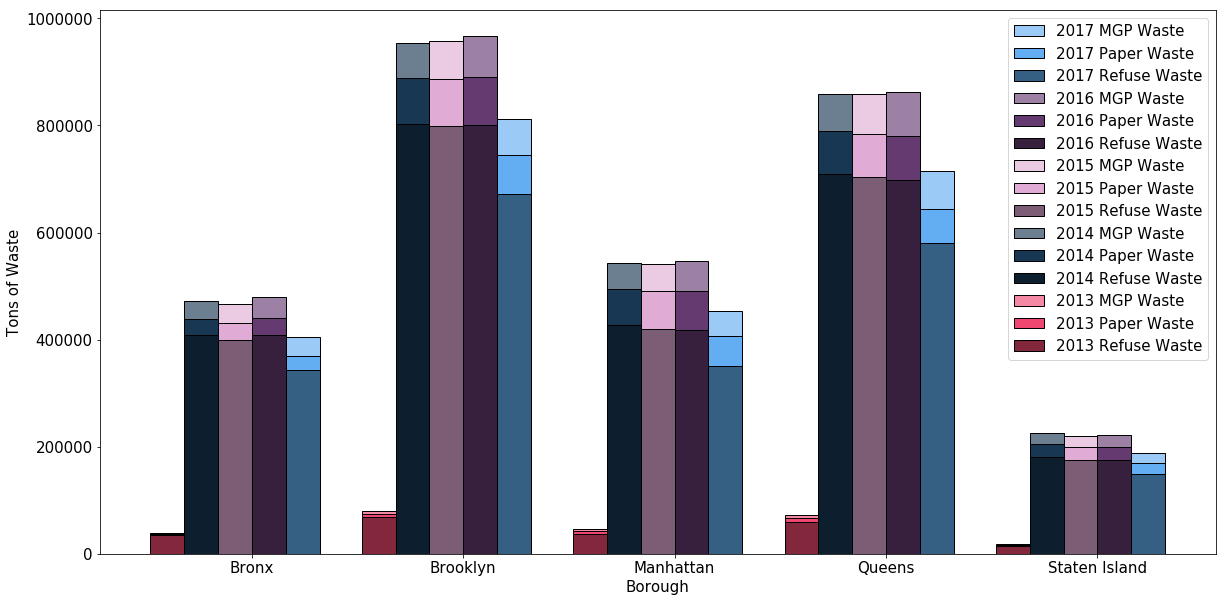

In [31]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)

space = 0.2

conditions = np.unique(df_yearly.iloc[:,0])
categories = np.unique(df_yearly.iloc[:,1])

n = len(conditions)

width = (1 - space) / (len(conditions))
indeces = range(1, len(categories)+1)

for i,cond in enumerate(conditions):
    refuse = df_yearly[df_yearly.iloc[:,0] == cond].iloc[:,2].astype(np.float)
    paper = df_yearly[df_yearly.iloc[:,0] == cond].iloc[:,3].astype(np.float)
    mgp = df_yearly[df_yearly.iloc[:,0] == cond].iloc[:,4].astype(np.float)
    pos = [j - (1 - space) / 2. + i * width for j in indeces]
    
    ax.bar(pos, refuse, width=width, label=cond+' Refuse Waste', 
           color=colors2[i], edgecolor='black')
    ax.bar(pos, paper, width=width, label=cond+' Paper Waste', 
           color=colors1[i], edgecolor='black', bottom=refuse)
    ax.bar(pos, mgp, width=width, label=cond+' MGP Waste', 
           color=colors3[i], edgecolor='black', bottom=np.array(refuse)+np.array(paper))
    
# Set the x-axis tick labels to be equal to the categories
ax.set_xticks(indeces)
ax.set_xticklabels(categories)
# plt.setp(plt.xticks()[1], rotation=90)

ax.set_ylabel("Tons of Waste")
ax.set_xlabel("Borough")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right');
        

I tried to plot the annual tonnage of waste per borough, per year in a bar plot but could not find a good color scheme to work with the plot. But it would be interesting to get this data to fractions instead of absolute counts.

Reference on how to plot by group: http://emptypipes.org/2013/11/09/matplotlib-multicategory-barchart/

I managed to choose the colors from this site: https://coolors.co/f489a3-6b7f91-ebcae4-9c81a4-9bcaf6
Which provides a good way of checking how the colors would look to people with colorblindness.